# UNet

Originally developed for segmenting medical images, the U-Net model has also proven to be extremely effective for tasks such as inpainting images. Its unique architecture and properties make it an ideal tool for reconstructing missing portions of images, providing realistic and esthetic results. Thanks to its encoder-decoder architecture, the model is able to effectively extract the context of an image from a created representation of its features.


## Imports

In [ ]:
colab = False

if colab:
    from google.colab import drive
    import os

    drive.mount("/content/drive/")

    colab_path = "/content/drive/MyDrive/"
    os.makedirs(colab_path, exist_ok=True)
    os.chdir(colab_path)
    !pip install pytorch-lightning

In [19]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [20]:
data_dir = "data"  # directory where data will be saved

img_loader = 'pickle' # pickle or jpg

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"You will be using {device.type}")

You will be using cuda


## Data Loading

### Data from JPG

In [ ]:
class PairedImagesDataset(Dataset):
    """
    A PyTorch Dataset for loading paired images from directories.

    This Dataset loads paired images (corrupted and original) from directories.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.
    class_dirs : list
        The list of class directories.
    file_pairs : list
        The list of file pairs.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.transform = transform
        self.class_dirs = sorted(os.listdir(corrupted_dir))

        # Ensure the two directories have the same number of class directories
        assert len(self.class_dirs) == len(os.listdir(original_dir))

        self.file_pairs = [
            (class_dir, filename)
            for class_dir in self.class_dirs
            for filename in sorted(os.listdir(os.path.join(corrupted_dir, class_dir)))
        ]

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.file_pairs)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        class_dir, filename = self.file_pairs[idx]

        # Load the corrupted and original images
        img_corrupted = Image.open(self.corrupted_dir / class_dir / filename)
        img_original = Image.open(self.original_dir / class_dir / filename)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [ ]:
class PairedImagesDataModule(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from directories.

    This DataModule loads paired images (corrupted and original) from directories
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDataset(
                self.corrupted_dir / "train",
                self.original_dir / "train",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDataset(
                self.corrupted_dir / "val",
                self.original_dir / "val",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDataset(
                self.corrupted_dir / "test",
                self.original_dir / "test",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val, batch_size=self.batch_size, num_workers=os.cpu_count()
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test, batch_size=self.batch_size, num_workers=os.cpu_count()
        )

In [ ]:
if img_loader == 'jpg':
    original_dir = Path("data/divided_x64")
    corrupted_dir = Path("data/augmented_x64")

    data_module = PairedImagesDataModule(corrupted_dir, original_dir, batch_size=32)
    data_module.setup()

    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    test_loader = data_module.test_dataloader()

### Data from Pickle

In [5]:
class PairedImagesDatasetPickle(Dataset):
    """
    A PyTorch Dataset for loading paired images from pickle files.

    This Dataset loads paired images (corrupted and original) from pickle files.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_file : Path
        The pickle file containing the corrupted images.
    original_file : Path
        The pickle file containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_file: Path, original_file: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_file : Path
            The pickle file containing the corrupted images.
        original_file : Path
            The pickle file containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_file = corrupted_file
        self.original_file = original_file
        self.transform = transform

        # Load the images from the pickle files
        with open(corrupted_file, "rb") as f:
            self.corrupted_images = pickle.load(f)
        with open(original_file, "rb") as f:
            self.original_images = pickle.load(f)

        # Ensure the two files have the same number of images
        assert len(self.corrupted_images) == len(self.original_images)

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.corrupted_images)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        img_corrupted = self.corrupted_images[idx]
        img_original = self.original_images[idx]

        # Convert the numpy arrays to PIL Images
        img_corrupted = Image.fromarray(img_corrupted)
        img_original = Image.fromarray(img_original)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [6]:
class PairedImagesDataModulePickle(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from pickle files.

    This DataModule loads paired images (corrupted and original) from pickle files
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images pickle files.
    original_dir : Path
        The directory containing the original images pickle files.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images in pickle files.
        original_dir : Path
            The directory containing the original images in pickle files.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDatasetPickle(
                self.corrupted_dir / "train.pkl",
                self.original_dir / "train.pkl",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDatasetPickle(
                self.corrupted_dir / "val.pkl",
                self.original_dir / "val.pkl",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDatasetPickle(
                self.corrupted_dir / "test.pkl",
                self.original_dir / "test.pkl",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

In [7]:
if img_loader == 'pickle':
    original_dir = Path("data/divided_x64")
    corrupted_dir = Path("data/augmented_x64")

    data_module_pickle = PairedImagesDataModulePickle(
        corrupted_dir, original_dir, batch_size=32
    )
    data_module_pickle.setup()

    train_loader_pickle = data_module_pickle.train_dataloader()
    val_loader_pickle = data_module_pickle.val_dataloader()
    test_loader_pickle = data_module_pickle.test_dataloader()

# Executes on colab: ~2 min

## Model

In [8]:
class UNet(nn.Module):
    """
    U-Net model implementation.

    Parameters
    ----------
    input_channels : int, optional
        Number of input channels, by default 3
    num_blocks : int, optional
        Number of encoder-decoder blocks, by default 3
    start_channels : int, optional
        Number of channels in the first encoder block, by default 8
    """

    def __init__(
        self, input_channels: int = 3, num_blocks: int = 3, start_channels: int = 8
    ) -> None:
        """
        Initialize the U-Net model.

        Parameters
        ----------
        input_channels : int, optional
            Number of input channels, by default 3
        num_blocks : int, optional
            Number of encoder-decoder blocks, by default 3
        start_channels : int, optional
            Number of channels in the first encoder block, by default 8
        """
        super().__init__()
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()

        self.encoders.append(EncoderStep(input_channels, start_channels))

        channels = start_channels
        for _ in range(1, num_blocks):
            self.encoders.append(EncoderStep(channels, channels * 2))
            channels *= 2

        self.bottleneck = nn.Sequential(
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels * 2, channels * 2, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        channels *= 2

        for _ in range(num_blocks):
            self.decoders.append(DecoderStep(channels, channels // 2))
            channels //= 2

        self.output = nn.Conv2d(channels, input_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the U-Net.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor.
        """
        skips = []
        for encoder in self.encoders:
            x, skip = encoder(x)
            skips.append(skip)

        x = self.bottleneck(x)

        for decoder, skip in zip(self.decoders, reversed(skips)):
            x = decoder(x, skip)

        x = self.output(x)
        return x


class EncoderStep(nn.Module):
    """
    Encoder step in U-Net.

    Parameters
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """

    def __init__(self, in_channels: int, out_channels: int) -> None:
        """
        Initialize the encoder step.

        Parameters
        ----------
        in_channels : int
            Number of input channels.
        out_channels : int
            Number of output channels.
        """
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the encoder step.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor.
        """
        x = self.block(x)
        x_polled = self.pool(x)
        return x_polled, x


class DecoderStep(nn.Module):
    """
    Decoder step in U-Net.

    Parameters
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """

    def __init__(self, in_channels: int, out_channels: int) -> None:
        """
        Initialize the decoder step.

        Parameters
        ----------
        in_channels : int
            Number of input channels.
        out_channels : int
            Number of output channels.
        """
        super().__init__()
        self.upconv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the decoder step.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.
        skip : torch.Tensor
            Skip connection tensor.

        Returns
        -------
        torch.Tensor
            Output tensor.
        """
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.block(x)
        return x

In [22]:
class UnetTrainer(pl.LightningModule):
    """
    A PyTorch Lightning Module for training a U-Net model.

    This class handles the training, validation, and optimization of a U-Net model.

    Attributes
    ----------
    model : nn.Module
        The U-Net model to train.
    lr : float
        The learning rate for the optimizer.
    loss : nn.MSELoss
        The loss function to use in training and validation.

    Methods
    -------
    forward(x)
        Pass the input through the model.
    training_step(batch, batch_idx)
        Perform a training step.
    validation_step(batch, batch_idx)
        Perform a validation step.
    configure_optimizers()
        Configure the optimizer for the model.
    """

    def __init__(self, model: nn.Module, lr: float = 1e-3) -> None:
        """
        Initialize the UnetTrainer.

        Parameters
        ----------
        model : nn.Module
            The U-Net model to train.
        lr : float, optional
            The learning rate for the optimizer, by default 1e-3.
        """
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss = nn.MSELoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Pass the input through the model.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.

        Returns
        -------
        torch.Tensor
            The output of the model.
        """
        return self.model(x)

    def training_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        """
        Perform a training step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            The input and target tensors for the batch.
        batch_idx : int
            The index of the batch.

        Returns
        -------
        dict
            A dictionary with the loss for the step.
        """
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        """
        Perform a validation step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            The input and target tensors for the batch.
        batch_idx : int
            The index of the batch.

        Returns
        -------
        dict
            A dictionary with the loss for the step.
        """
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log("val_loss", loss)
        print(f"Validation loss: {loss}")
        plt.style.use("default")

        y_pred = y_pred[0].detach().cpu().numpy().transpose(1, 2, 0)
        y_pred = (y_pred + 1) / 2  # Normalize to [0, 1]
        y = y[0].detach().cpu().numpy().transpose(1, 2, 0)
        y = (y + 1) / 2  # Normalize to [0, 1]

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(y_pred)
        axs[0].set_title("Predicted")
        axs[1].imshow(y)
        axs[1].set_title("Ground Truth")
        plt.suptitle(f"Epoch {self.current_epoch}")
        plt.show()

        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configure the optimizer for the model.

        Returns
        -------
        torch.optim.Optimizer
            The optimizer for the model.
        """
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [10]:
def evaluate(model: nn.Module, test_loader: DataLoader) -> None:
    """
    Evaluate the model on a test dataset and display the results.

    This function computes the MSE, NRMSE, PSNR, and SSIM metrics for the model's predictions
    on the test dataset. It also displays the corrupted, predicted, and ground truth images
    for the first 5 samples in the test dataset.

    Parameters
    ----------
    model : nn.Module
        The model to evaluate.
    test_loader : DataLoader
        The DataLoader for the test dataset.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the computed metrics for each sample in the test dataset.
    """
    model.eval()
    fig, axs = plt.subplots(3, 5, figsize=(15, 15))
    metrics = {"MSE": [], "NRMSE": [], "PSNR": [], "SSIM": []}
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x, y = x.to(model.device), y.to(model.device)
            y_pred = model(x)
            y_pred = y_pred[0].detach().cpu().numpy().transpose(1, 2, 0)
            y_pred = (y_pred + 1) / 2
            y = y[0].detach().cpu().numpy().transpose(1, 2, 0)
            y = (y + 1) / 2
            x = x[0].detach().cpu().numpy().transpose(1, 2, 0)
            x = (x + 1) / 2

            mse = mean_squared_error(y.flatten(), y_pred.flatten())
            nrmse = np.sqrt(mse) / (np.max(y) - np.min(y))
            psnr = peak_signal_noise_ratio(y, y_pred, data_range=y.max() - y.min())
            ssim = structural_similarity(
                y, y_pred, channel_axis=-1, data_range=y.max() - y.min()
            )

            metrics["MSE"].append(mse)
            metrics["NRMSE"].append(nrmse)
            metrics["PSNR"].append(psnr)
            metrics["SSIM"].append(ssim)

            if idx < 5:
                axs[0, idx].imshow(x)
                axs[0, idx].set_title("Corrupted Image")
                axs[1, idx].imshow(y_pred)
                axs[1, idx].set_title("Predicted")
                axs[2, idx].imshow(y)
                axs[2, idx].set_title("Ground Truth")

    plt.show()

    metrics_df = pd.DataFrame(metrics)
    summary = metrics_df.describe()
    mean_min_summary = summary.loc[["max", "mean", "min"]]
    display(mean_min_summary)

    return metrics_df

## Train

In [ ]:
model = UNet(start_channels=16).to(device)

# show num of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 482067


In [ ]:
UNet_trainer = UnetTrainer(model)

In [ ]:
trainer = pl.Trainer(
    accelerator=device.type,
    max_epochs=30,
    check_val_every_n_epoch=5,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | UNet    | 482 K 
1 | loss  | MSELoss | 0     
----------------------------------
482 K     Trainable params
0         Non-trainable params
482 K     Total params
1.928     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.3170945346355438


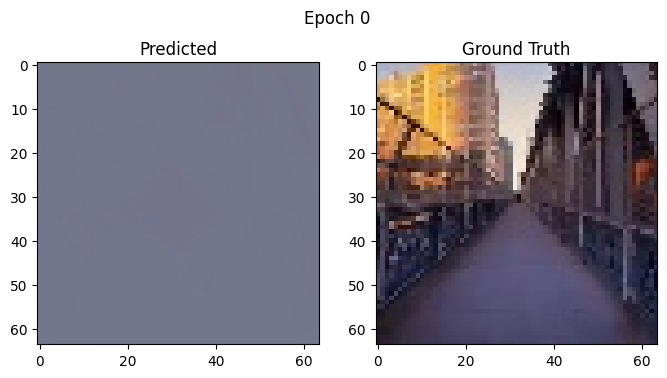

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.03824993968009949


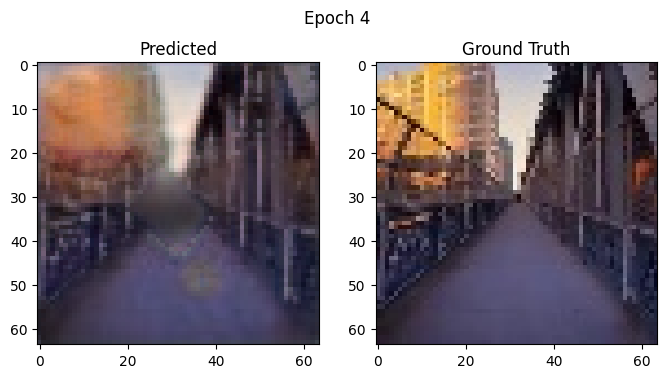

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.026991020888090134


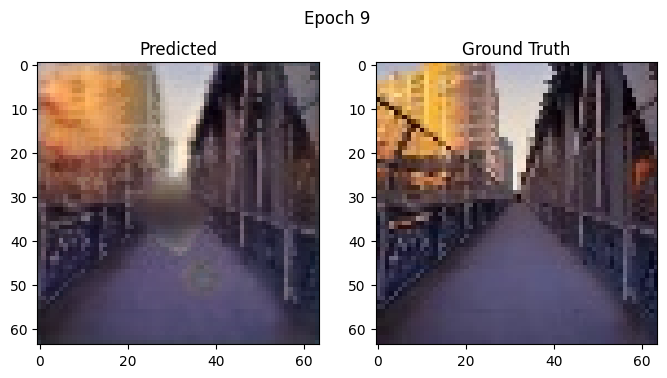

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.022707201540470123


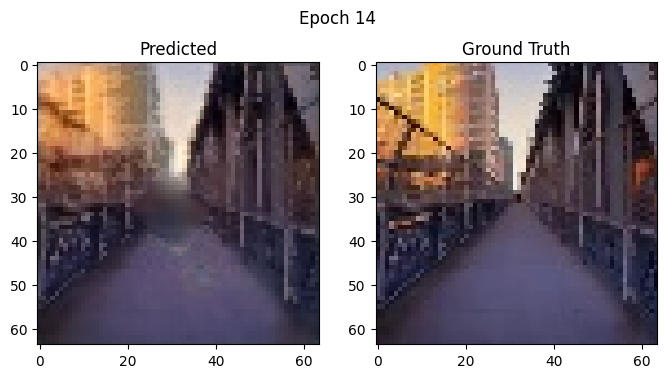

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.031970005482435226


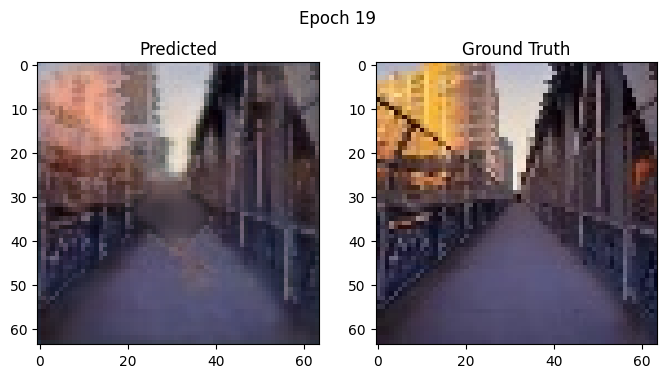

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.02604365348815918


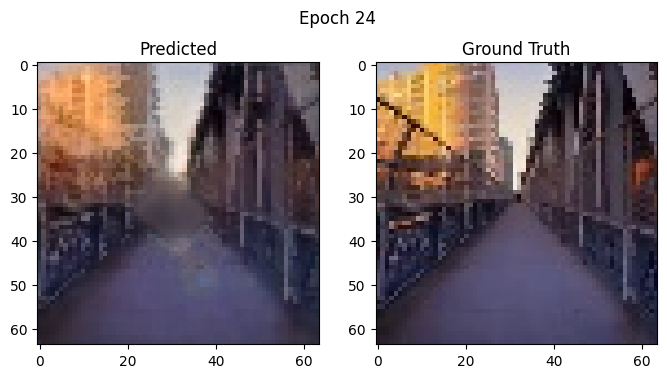

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.02151687815785408


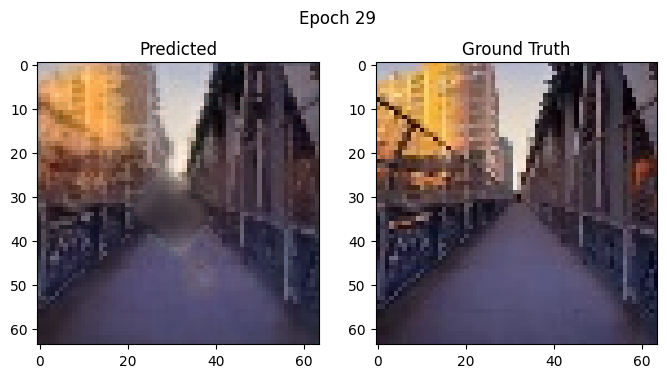

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
trainer.fit(UNet_trainer, train_loader, val_loader)

In [ ]:
%load_ext tensorboard

%tensorboard --logdir lightning_logs/

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


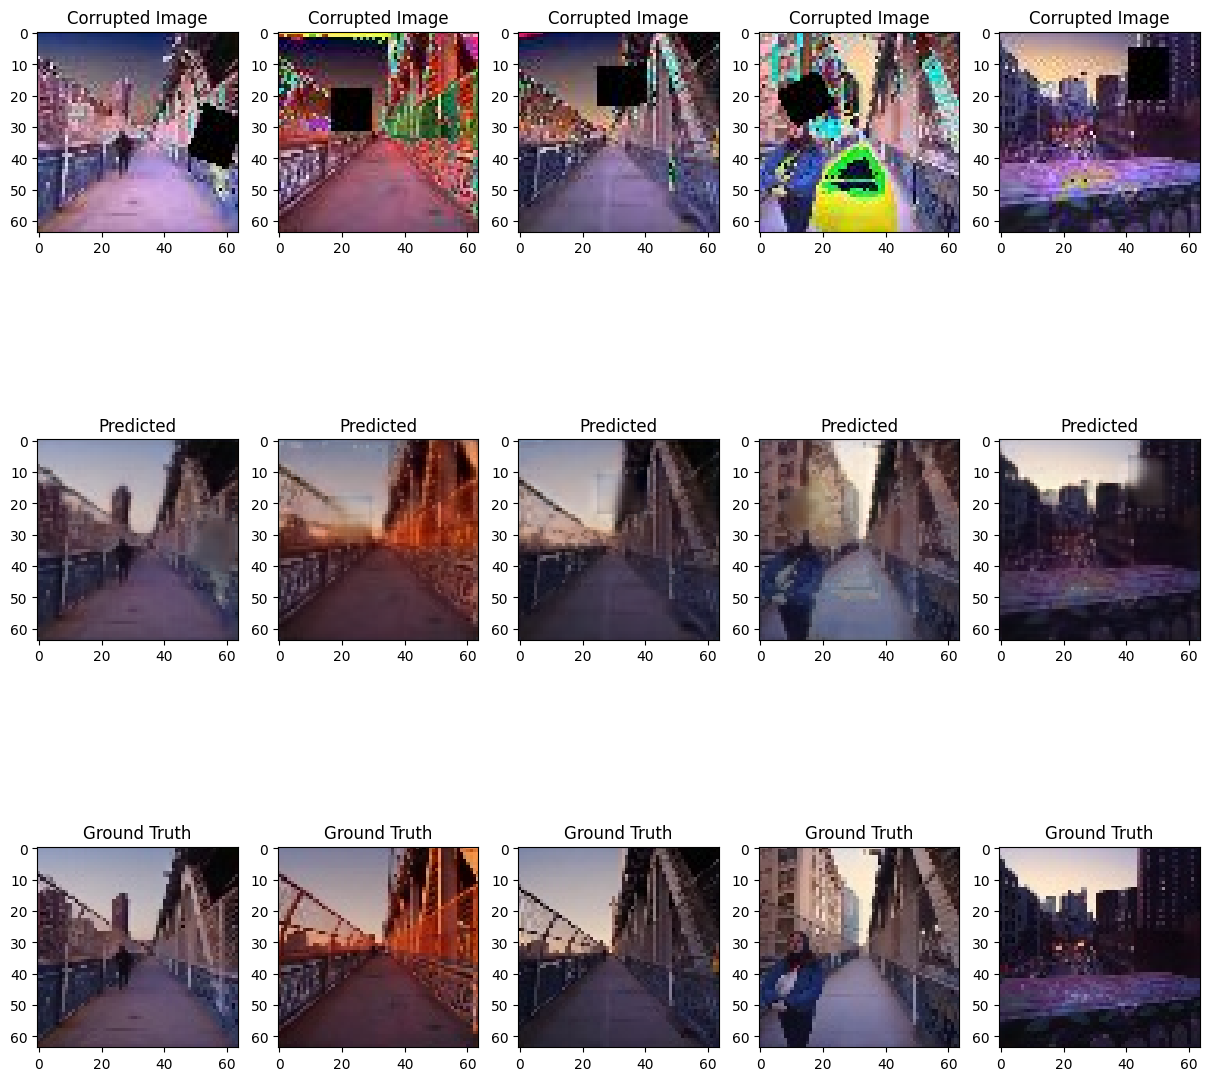

MSE     NRMSE       PSNR      SSIM
max   0.010118  0.114511  28.867353  0.934879
mean  0.004065  0.065525  23.969002  0.830932
min   0.000812  0.036027  18.823051  0.661782

In [ ]:
eveluate_metrics = evaluate(UNet_trainer, test_loader)

## Experiments

In [11]:
def train_validate_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    max_epochs: int = 30,
    lr: float = 1e-3,
) -> pd.DataFrame:
    """
    Train and validate a model on the given datasets.

    This function trains the model on the training dataset and validates it on the validation dataset.
    It logs the training and validation losses and displays the predicted and ground truth images
    for the first 5 samples in the validation dataset.

    Parameters
    ----------
    model : nn.Module
        The model to train and validate.
    train_loader : DataLoader
        The DataLoader for the training dataset.
    val_loader : DataLoader
        The DataLoader for the validation dataset.
    max_epochs : int, optional
        The maximum number of epochs to train the model, by default 30.
    lr : float, optional
        The learning rate for the optimizer, by default 1e-3.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the computed metrics for each sample in the validation dataset.
    """
    model = model.to(device)
    model_trainer = UnetTrainer(model, lr=lr)
    trainer = pl.Trainer(
        accelerator=device.type,
        max_epochs=max_epochs,
        check_val_every_n_epoch=5,
        limit_val_batches=1,
    )

    trainer.fit(model_trainer, train_loader, val_loader)

    evaluate_metrics = evaluate(model_trainer, val_loader)

    metrics = evaluate_metrics.describe().loc[["mean"]]

    return metrics

In [12]:
def plot_metrics(metrics_df: pd.DataFrame, title: str, metric: str) -> None:
    """
    Plot the computed metrics for each sample in the dataset.

    This function plots the computed metrics for each sample in the dataset
    as a box plot.

    Parameters
    ----------
    metrics_df : pd.DataFrame
        A DataFrame with the computed metrics for each sample in the dataset.
    title : str
        The title for the plot.
    metric : str
        The metric to use as X-ax label.
    """

    plt.style.use("ggplot")
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=12)

    for i, col in enumerate(metrics_df.columns):
        ax = axs[i//2, i%2]
        cmap = plt.get_cmap("brg")
        colors = cmap(np.linspace(0, 1, len(metrics_df[col])))
        ax.bar(metrics_df.index, metrics_df[col], color=colors)
        ax.set_title(col)
        ax.set_xlabel(metric)
        ax.set_ylabel(f"{col} Value")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### Unet Channels

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet    | 30.4 K | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
30.4 K    Trainable params
0         Non-trainable params
30.4 K    Total params
0.121     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.5526267290115356


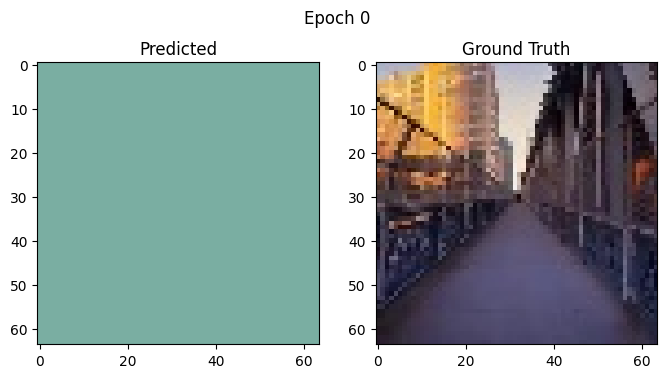

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.29029977321624756


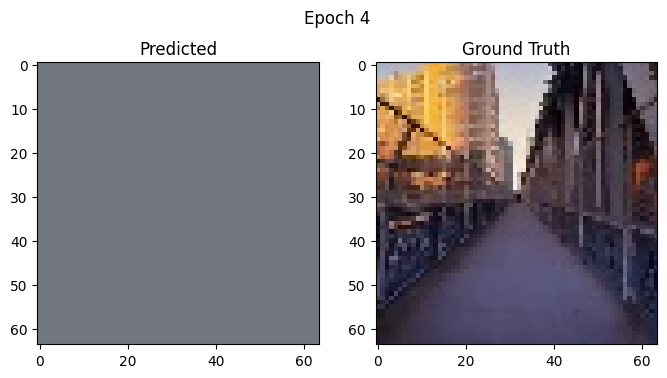

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.29028308391571045


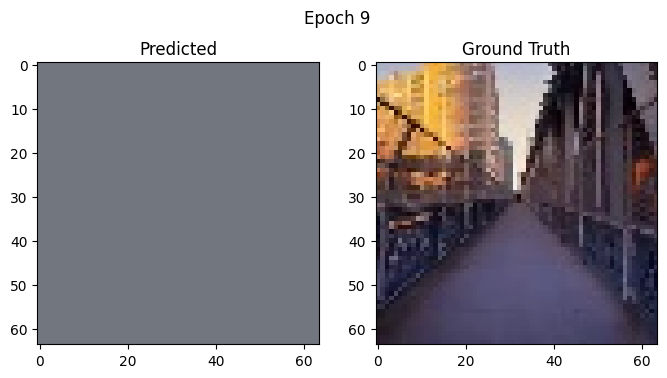

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.2894020080566406


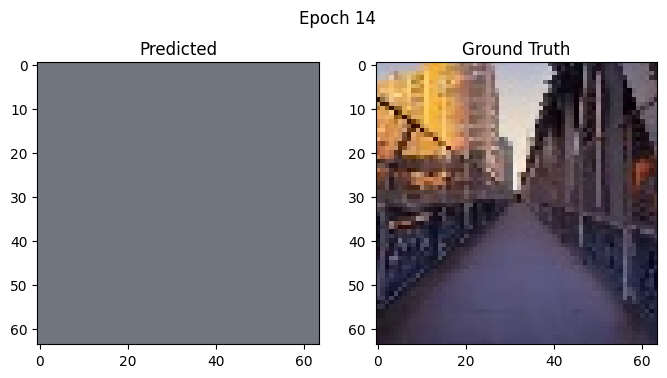

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.29010963439941406


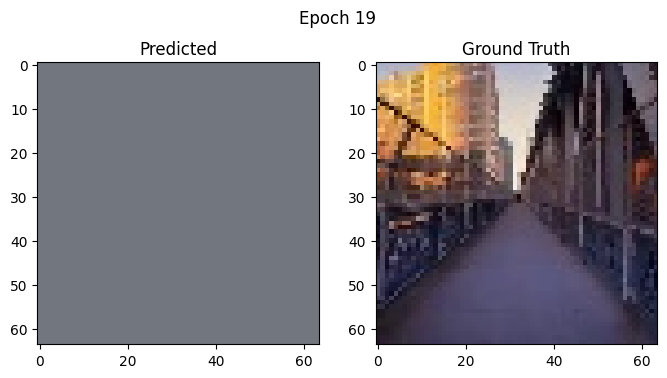

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


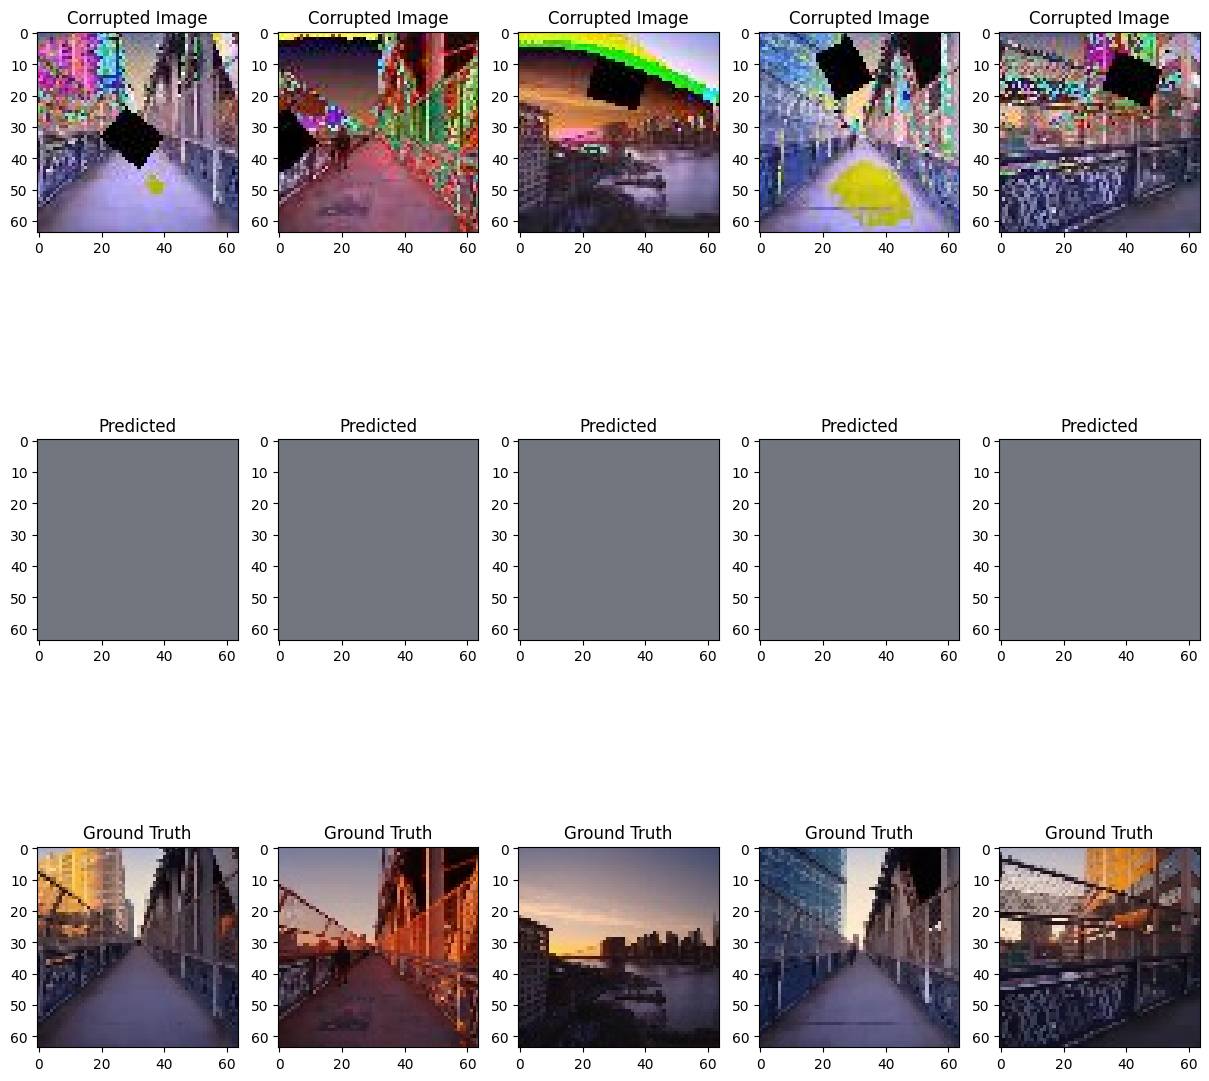

MSE     NRMSE       PSNR      SSIM
max   0.096273  0.310280  14.688595  0.502202
mean  0.057372  0.251557  12.035172  0.206664
min   0.025982  0.184319  10.164937  0.085981

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet    | 120 K  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.483     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.33597511053085327


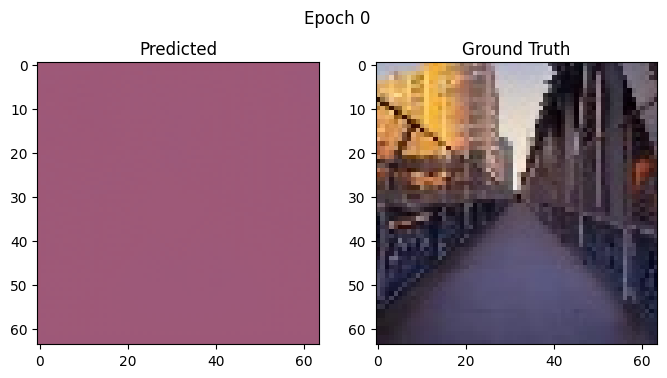

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.04597540944814682


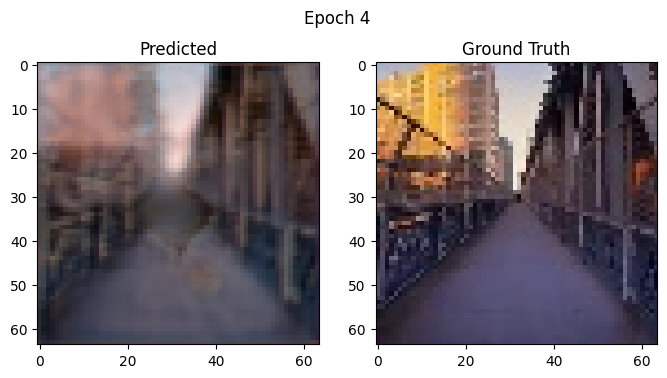

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.03670746833086014


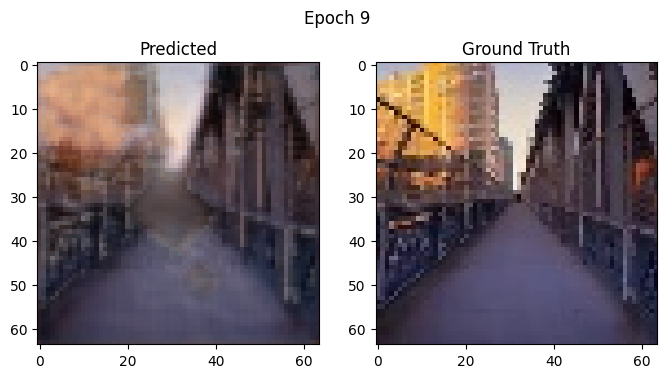

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.031963419169187546


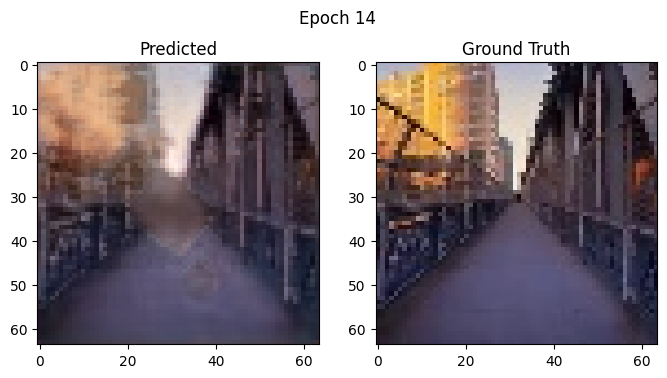

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.029236620292067528


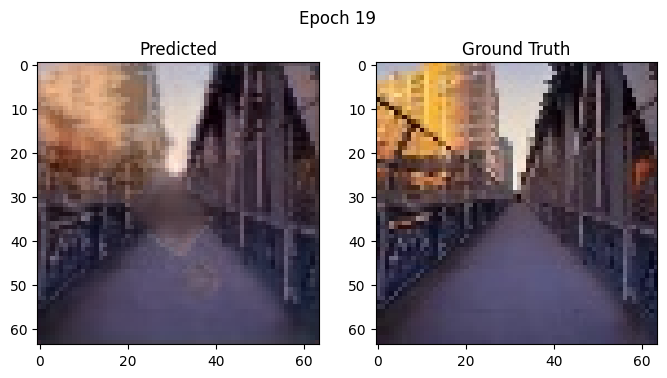

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


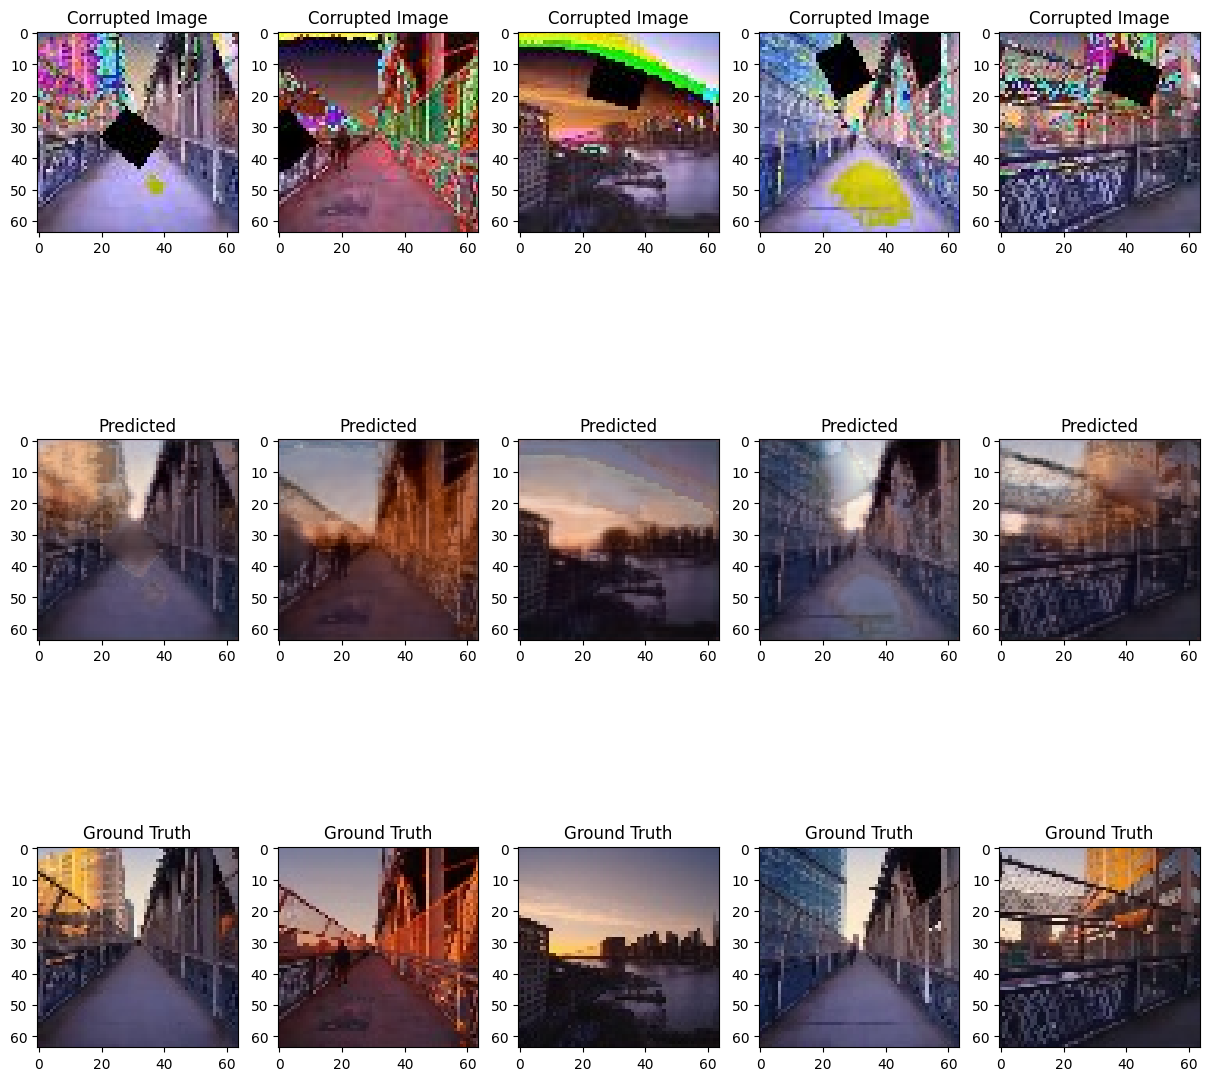

MSE     NRMSE       PSNR      SSIM
max   0.014512  0.120465  28.650978  0.896410
mean  0.005600  0.077106  22.483057  0.773563
min   0.000899  0.036936  18.382807  0.544152

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet    | 482 K  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
482 K     Trainable params
0         Non-trainable params
482 K     Total params
1.928     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.3417209982872009


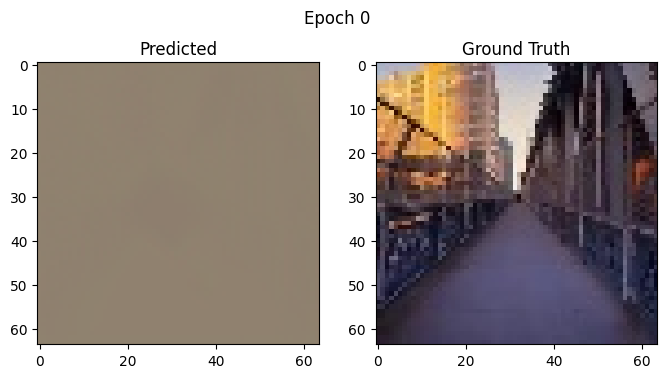

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.03612982854247093


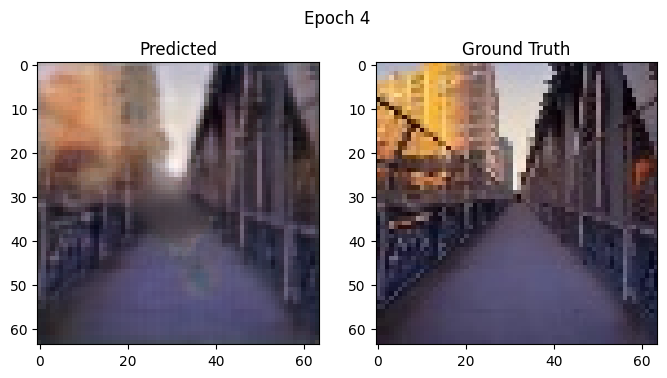

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.02781721018254757


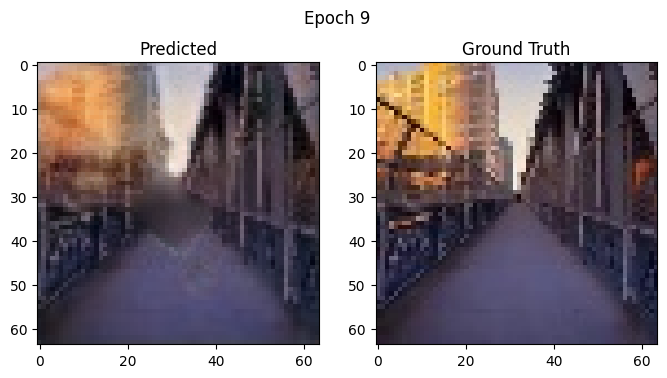

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.022795874625444412


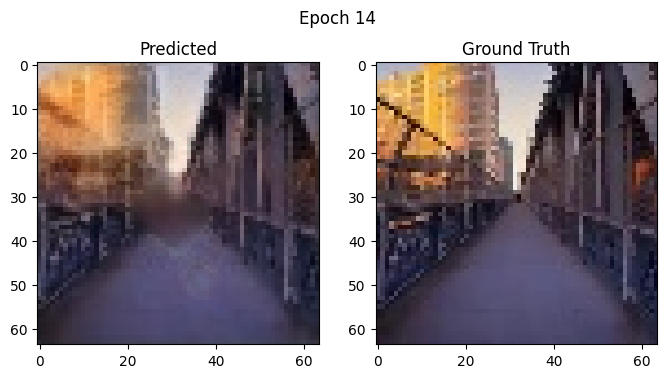

Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.020791247487068176


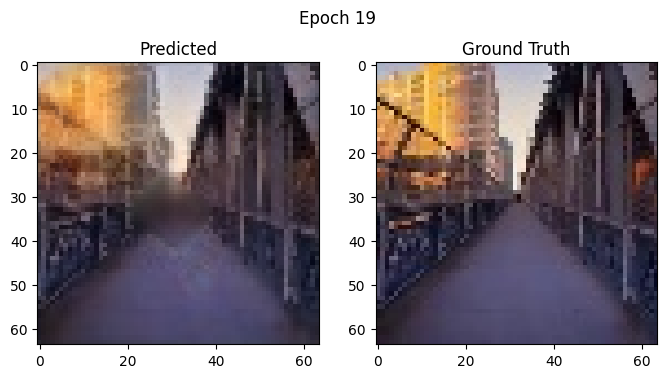

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


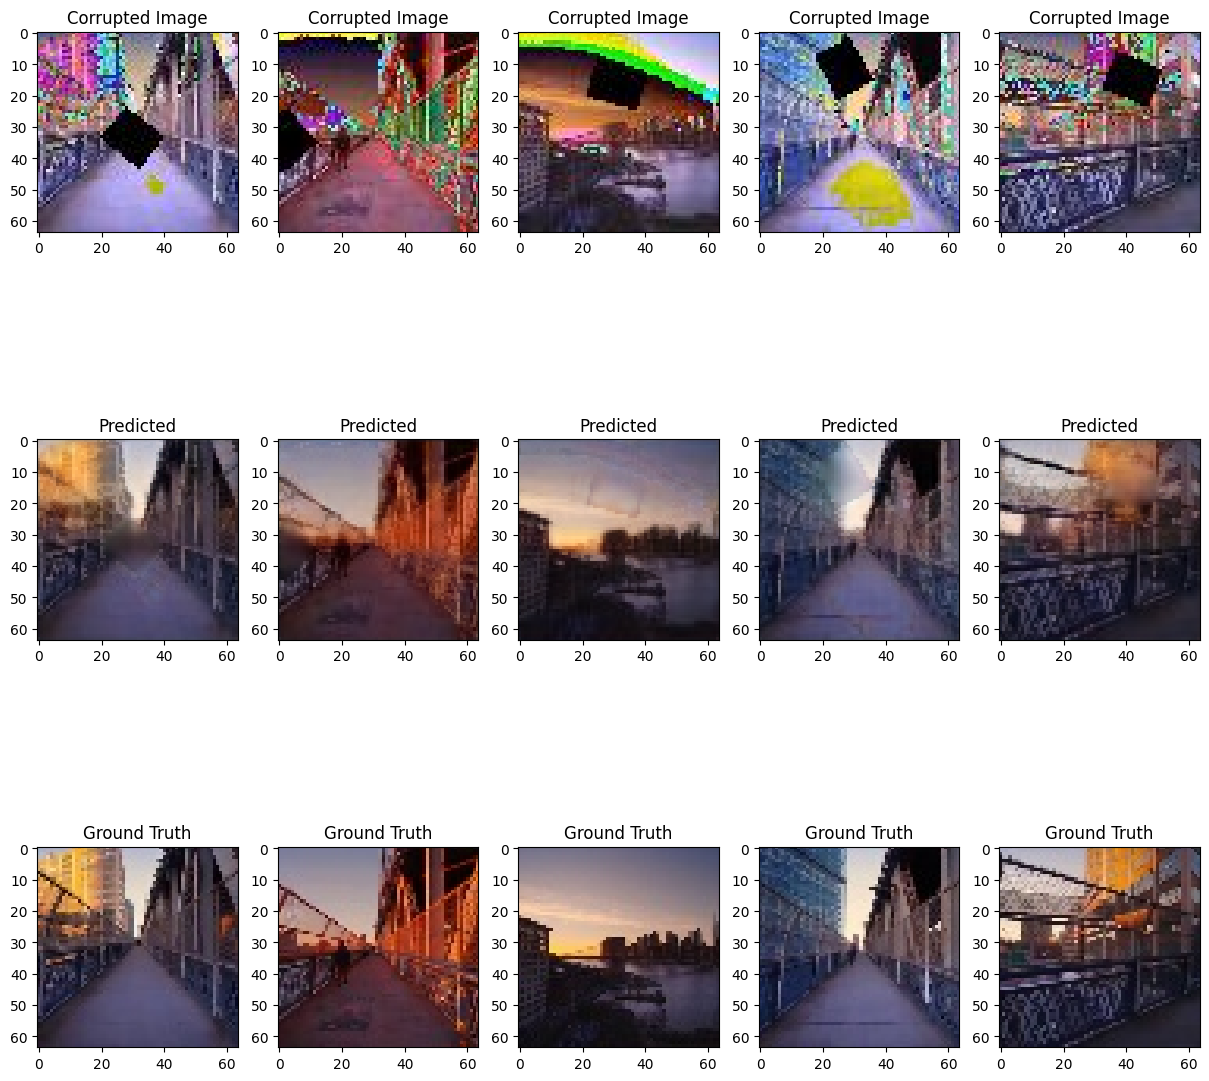

MSE     NRMSE       PSNR      SSIM
max   0.012039  0.112775  30.765344  0.930757
mean  0.003794  0.062195  24.461186  0.834091
min   0.000552  0.028956  18.955756  0.684494

In [ ]:
start_channels = [4, 8, 16]
start_channels_results = {}

for start_channel in start_channels:
    tmp_model = UNet(start_channels=start_channel)
    start_channels_results[f"{start_channel}"] = train_validate_model(tmp_model, train_loader, val_loader, max_epochs=20)


In [ ]:
start_channels_df = pd.concat(start_channels_results.values(), keys=start_channels_results.keys())
start_channels_df.index = start_channels_df.index.droplevel(1)
display(start_channels_df)

MSE     NRMSE       PSNR      SSIM
4   0.057372  0.251557  12.035172  0.206664
8   0.005600  0.077106  22.483057  0.773563
16  0.003794  0.062195  24.461186  0.834091

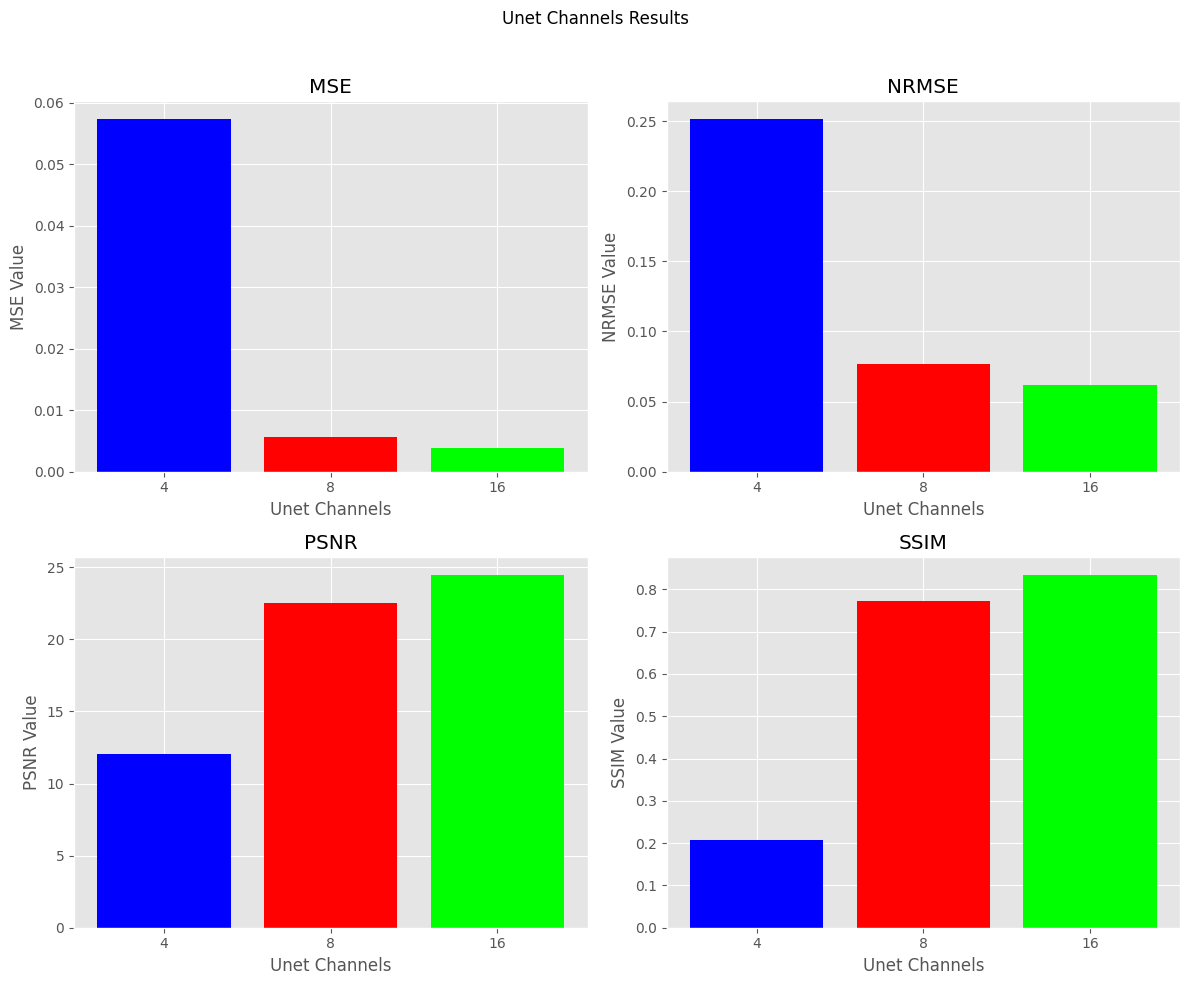

In [ ]:
plot_metrics(start_channels_df, "Unet Channels Results", "Unet Channels")

### Unet Blocks

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet    | 29.5 K | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
29.5 K    Trainable params
0         Non-trainable params
29.5 K    Total params
0.118     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.3383321762084961


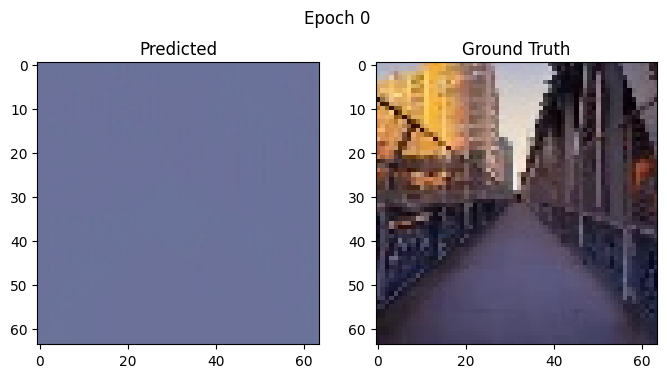

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.061777472496032715


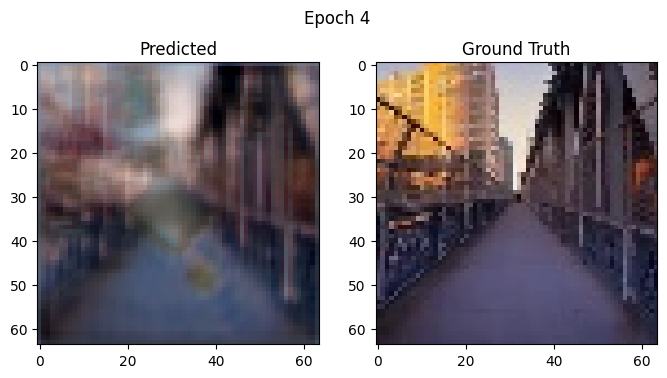

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.05074630677700043


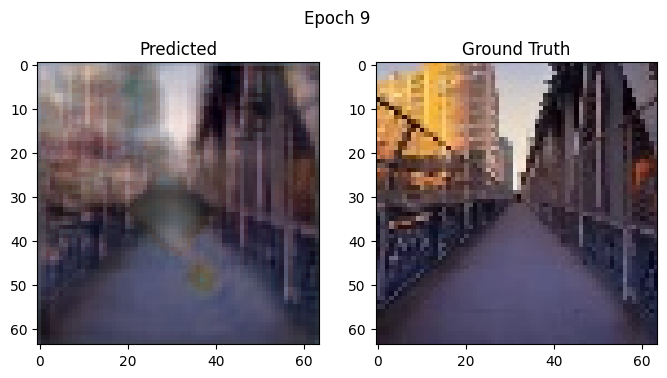

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.04748519882559776


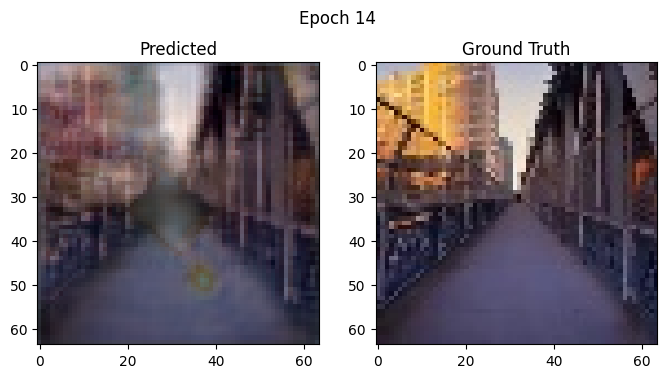

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.04439369961619377


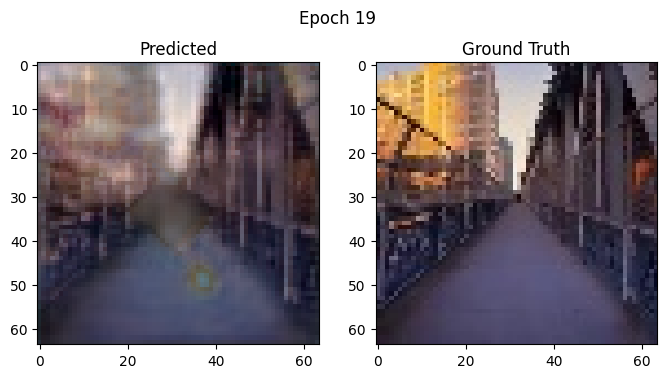

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


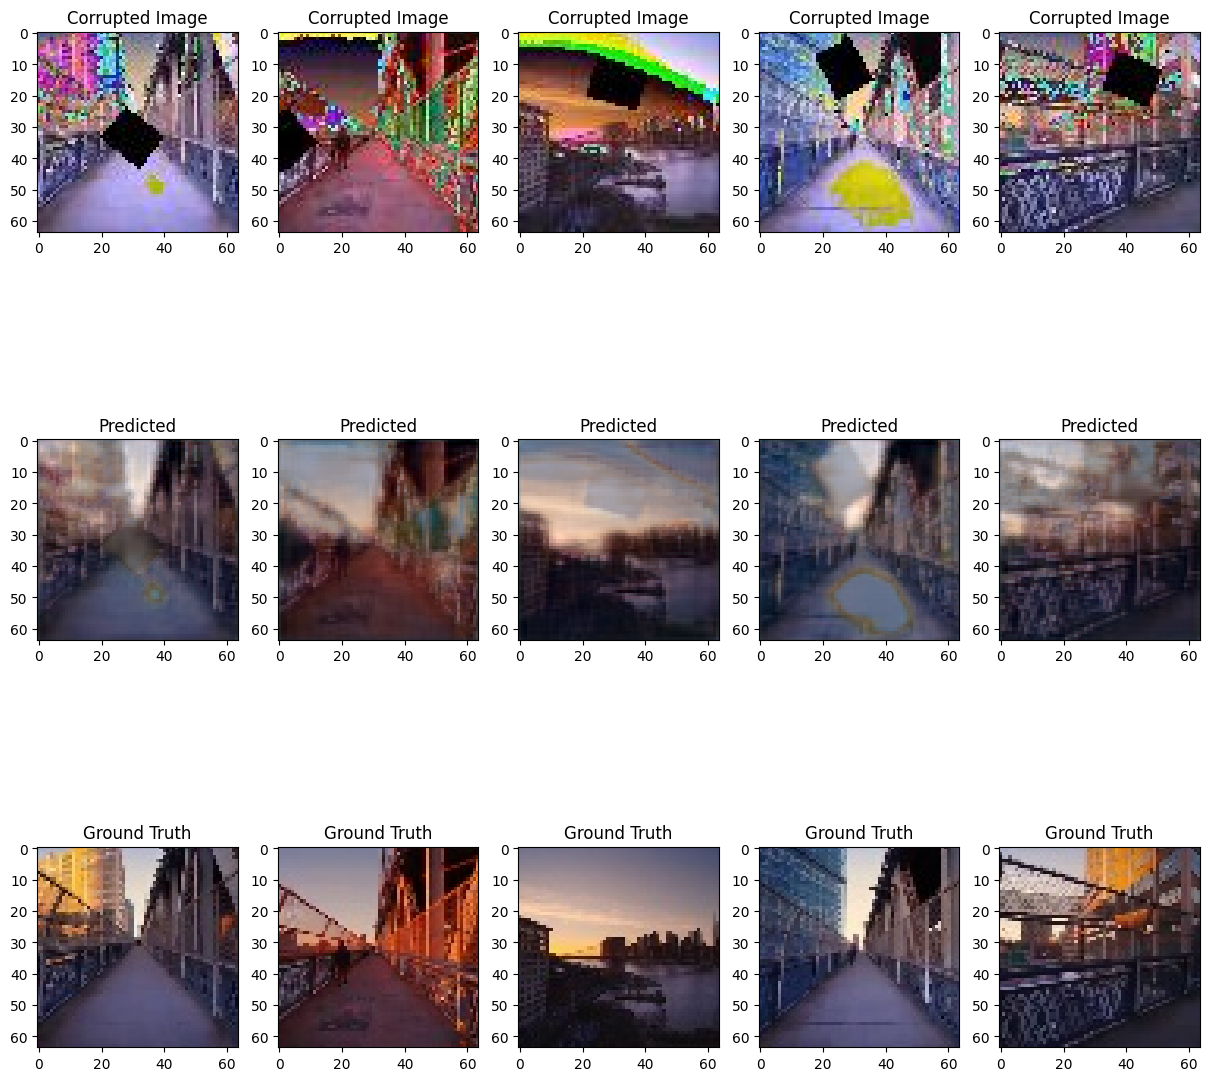

MSE     NRMSE       PSNR      SSIM
max   0.073194  0.272683  24.863338  0.782228
mean  0.010119  0.102368  20.068010  0.662012
min   0.002150  0.057126  11.286852  0.416094

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet    | 120 K  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.483     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.36023396253585815


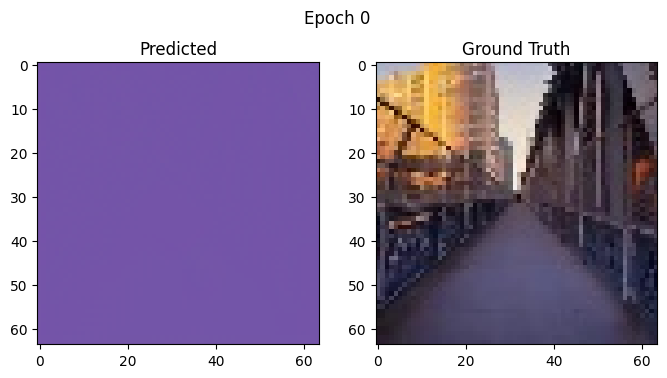

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.04897540062665939


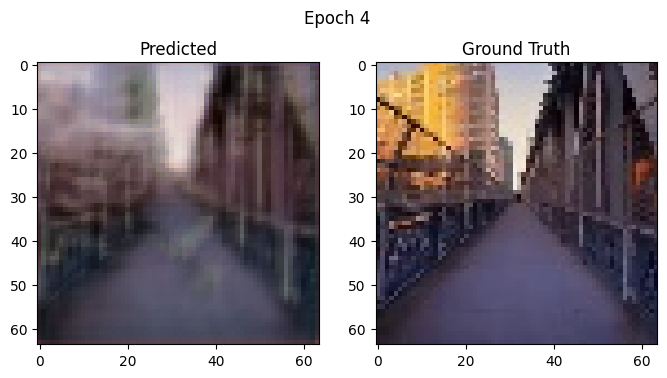

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.038067031651735306


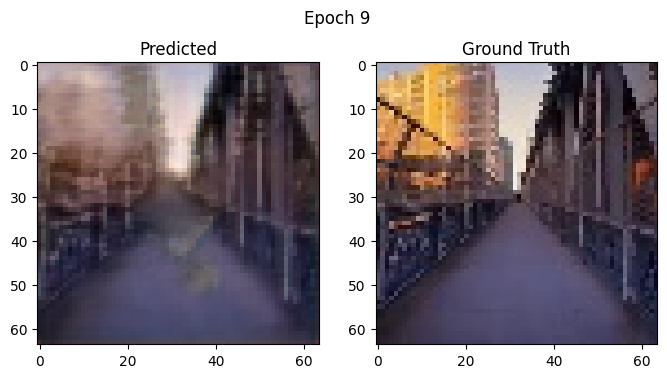

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.03320344537496567


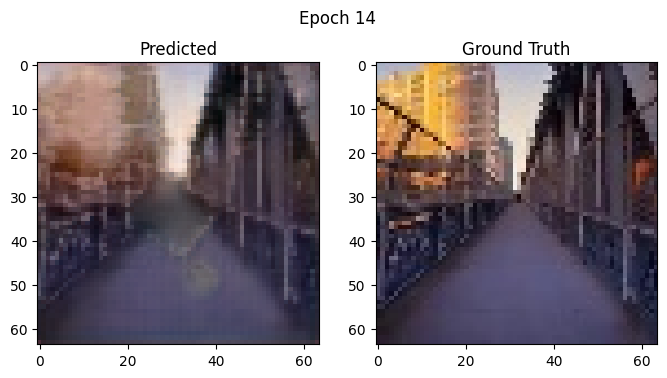

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.030812744051218033


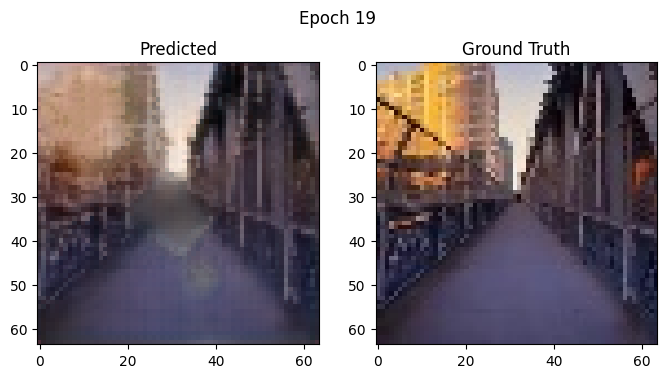

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


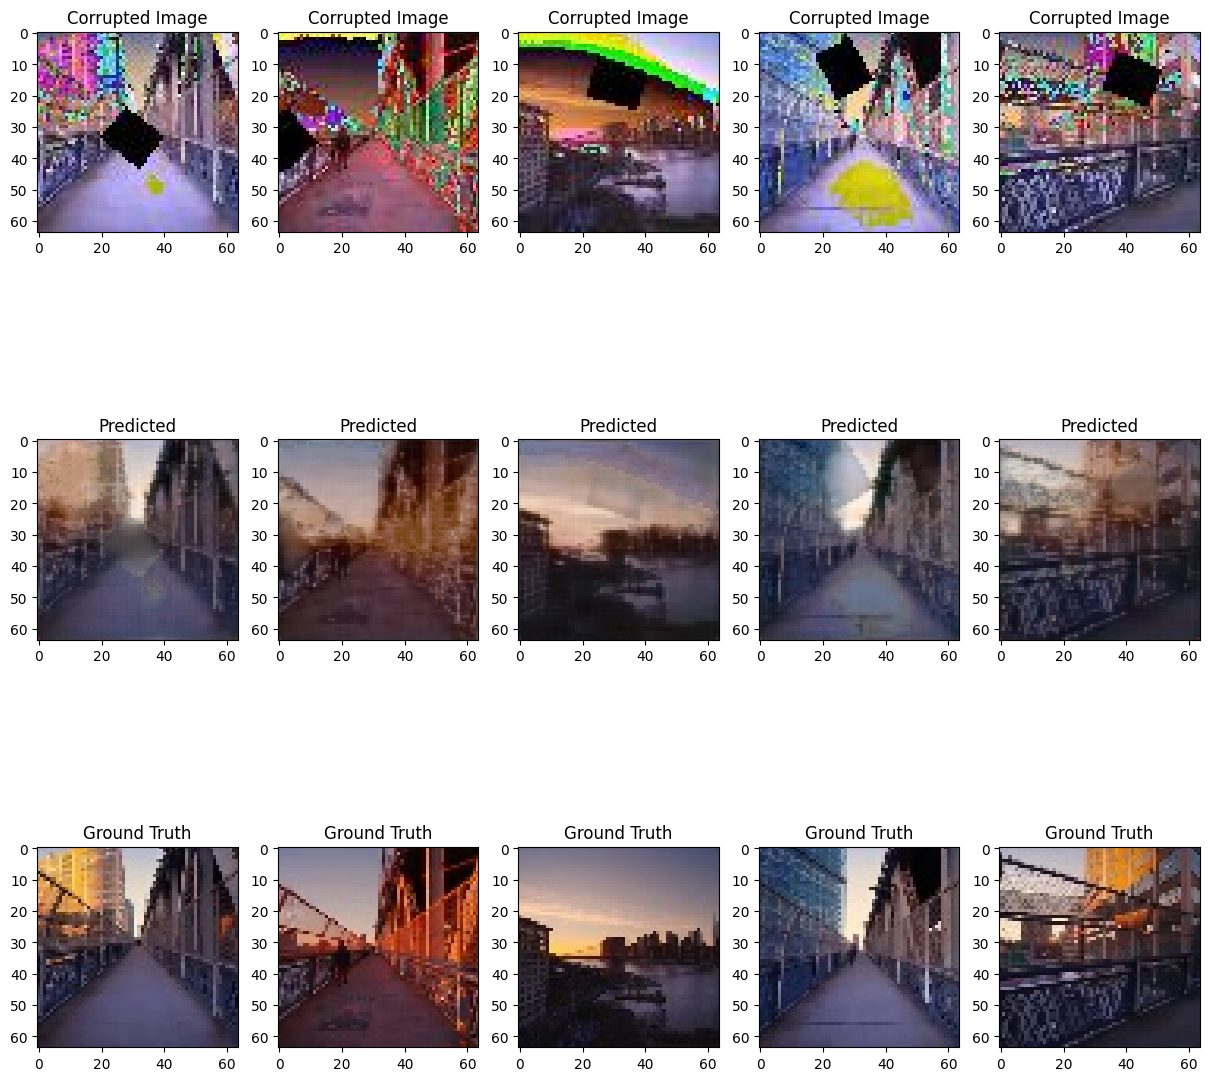

MSE     NRMSE       PSNR      SSIM
max   0.039551  0.206149  28.169788  0.883926
mean  0.006604  0.081421  22.124633  0.755946
min   0.001004  0.039040  13.716359  0.550701

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet    | 485 K  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
485 K     Trainable params
0         Non-trainable params
485 K     Total params
1.943     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.4607619643211365


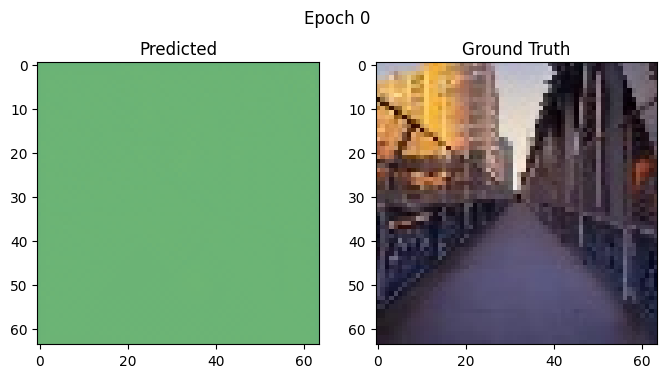

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.04535233601927757


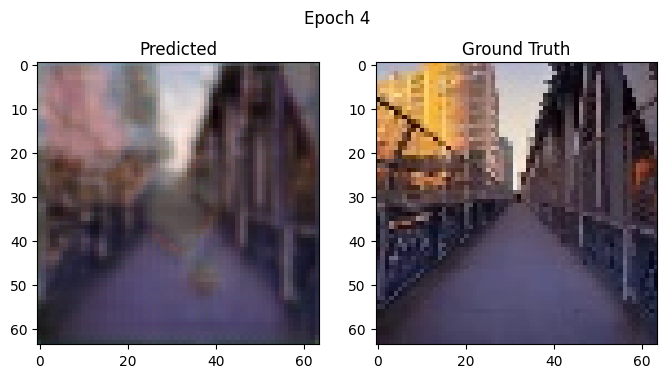

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.03504921495914459


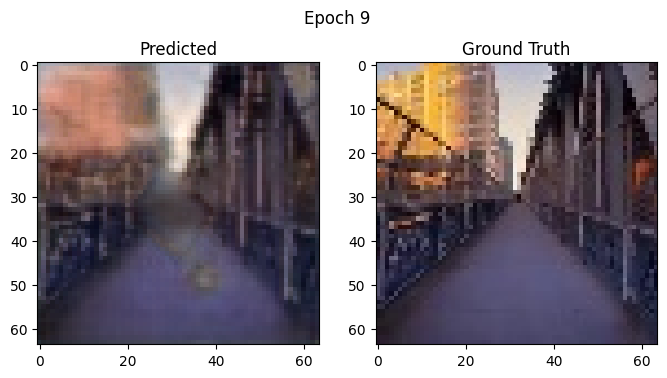

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.03012045845389366


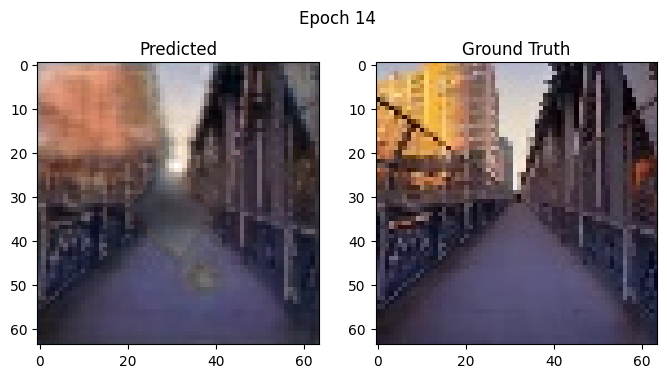

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.026366818696260452


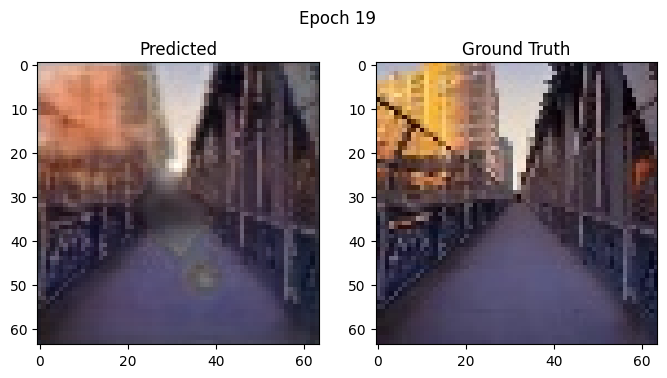

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


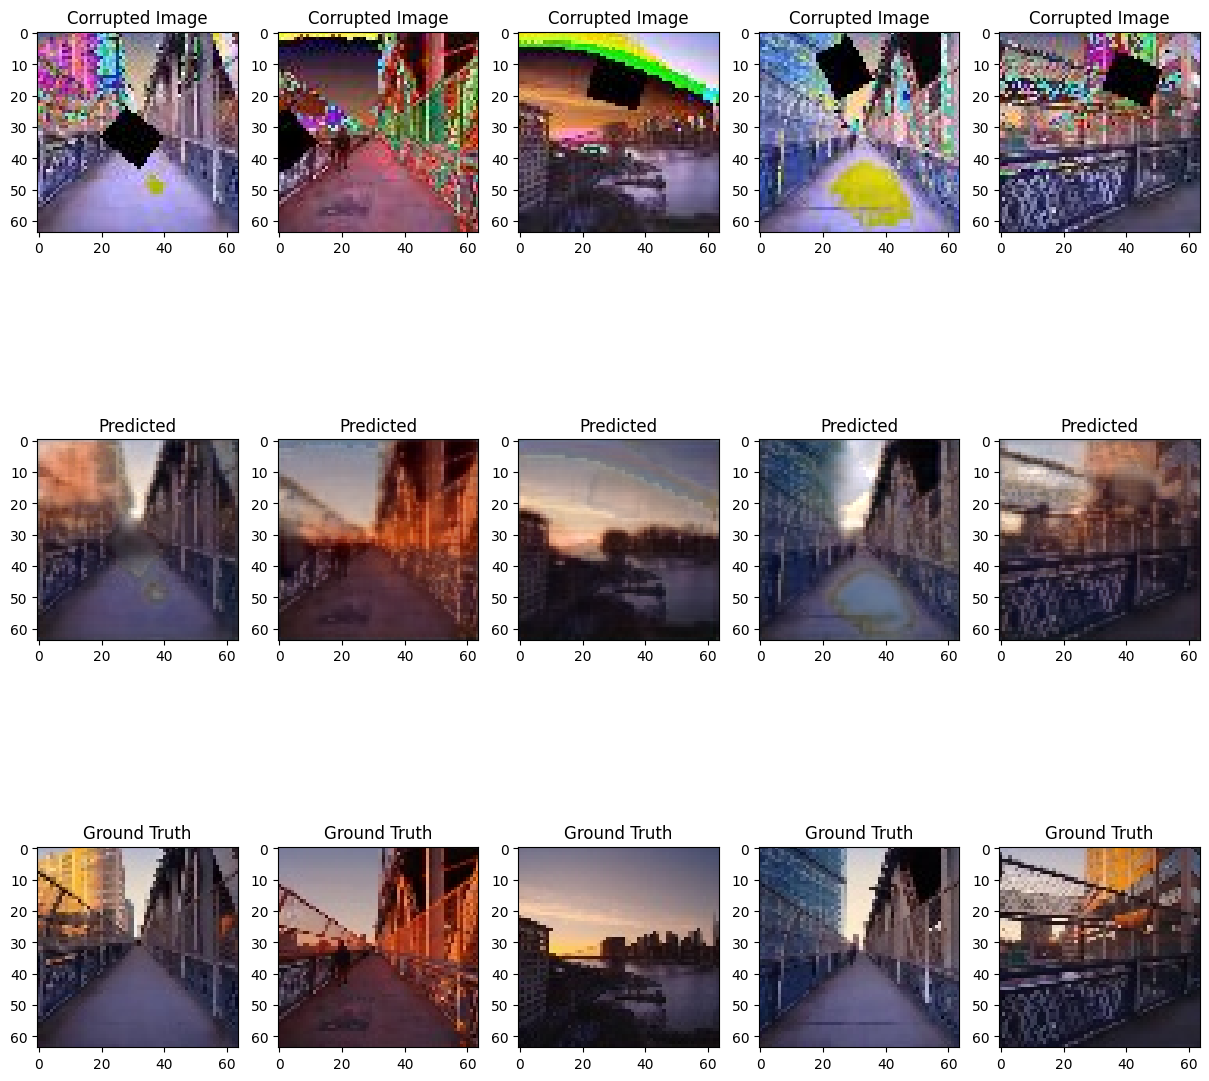

MSE     NRMSE       PSNR      SSIM
max   0.014371  0.124398  29.127248  0.891438
mean  0.005115  0.073131  22.974632  0.776160
min   0.000806  0.034965  18.103728  0.574254

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet    | 1.9 M  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.780     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.46147364377975464


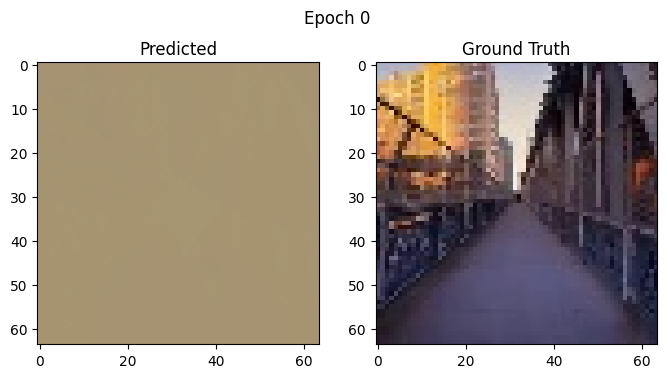

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.05021471902728081


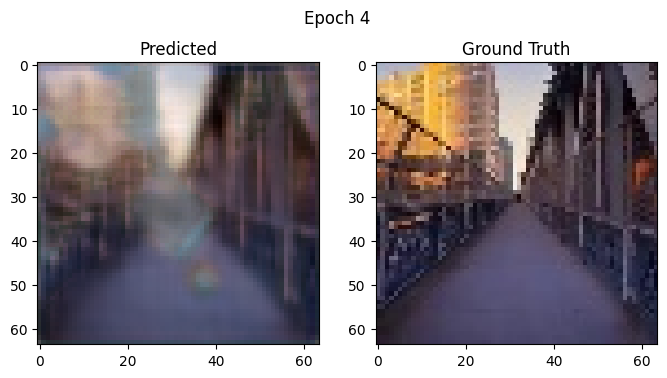

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.03429879993200302


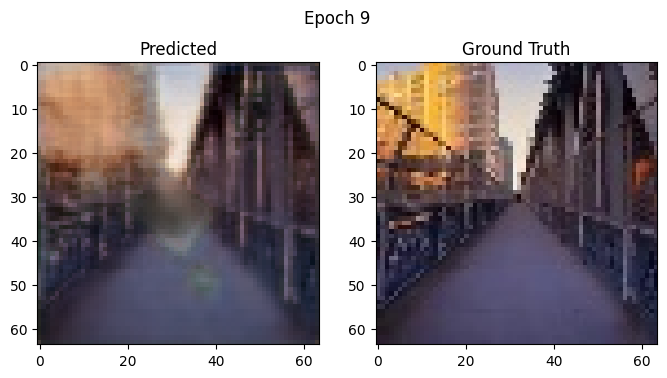

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.031077101826667786


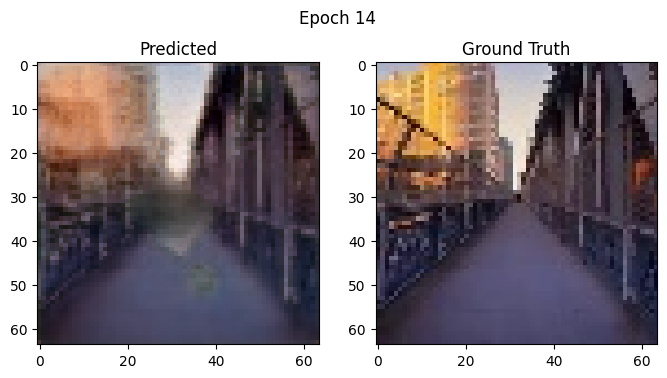

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.02726138010621071


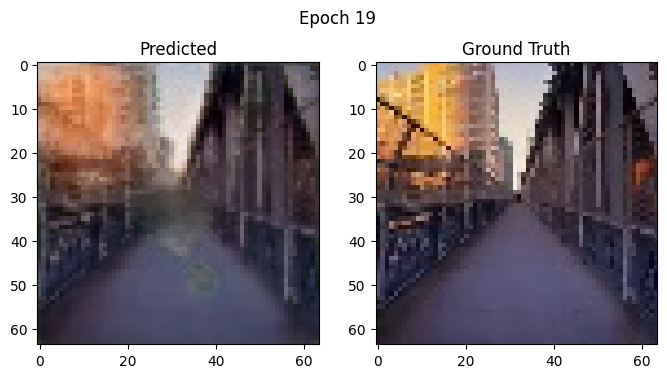

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


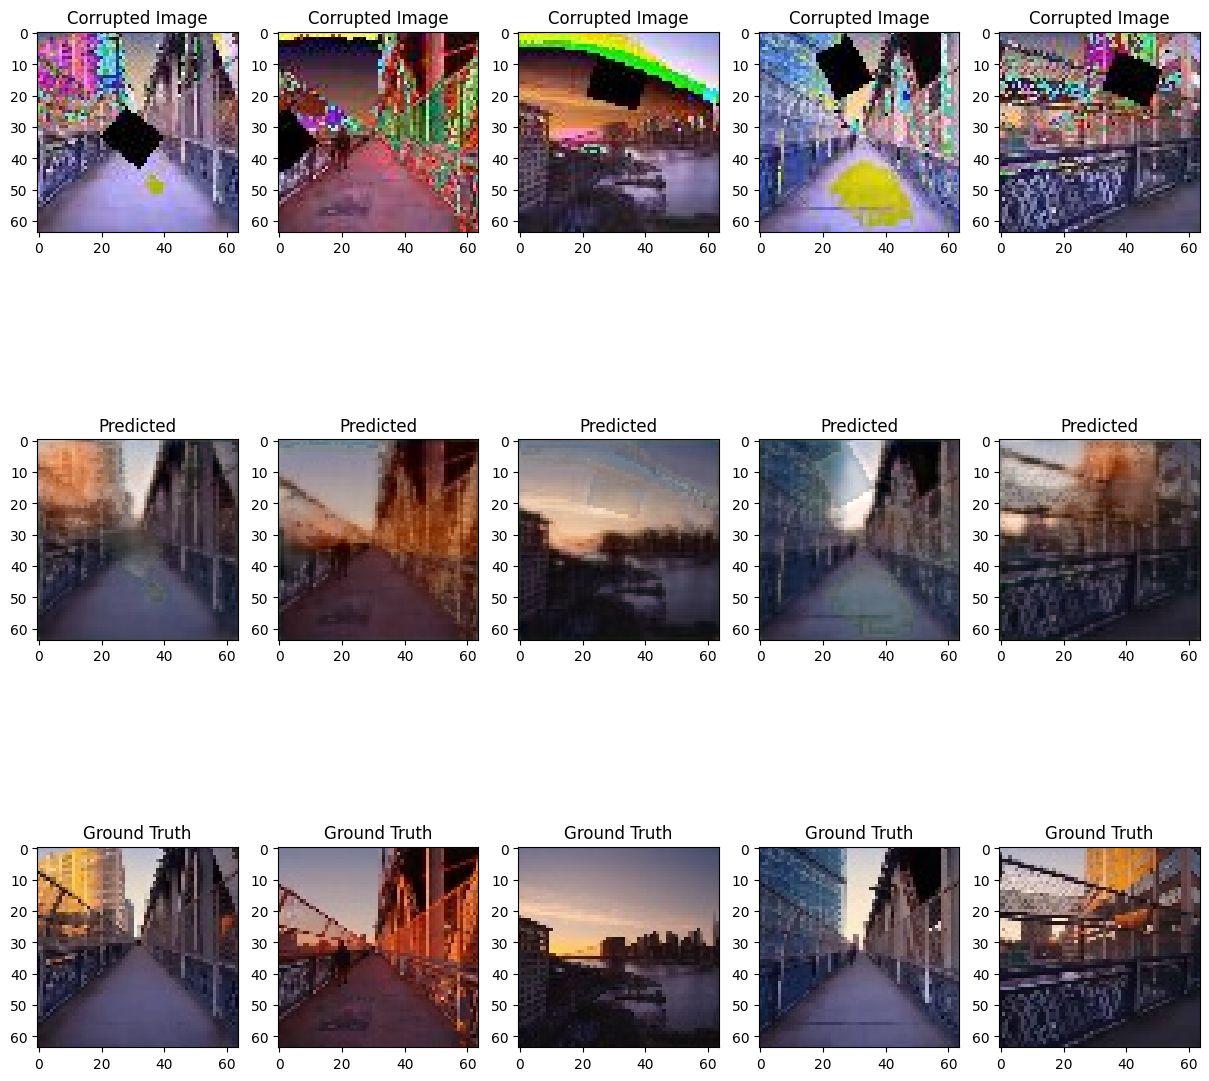

MSE     NRMSE       PSNR      SSIM
max   0.056273  0.239094  28.796062  0.909707
mean  0.005624  0.073909  23.033660  0.788653
min   0.000869  0.036324  12.428615  0.585287

In [23]:
num_blocks = [2, 3, 4, 5]
num_blocks_results = {}

for num_block in num_blocks:
    tmp_model = UNet(num_blocks=num_block)
    num_blocks_results[f"{num_block}"] = train_validate_model(tmp_model, train_loader, val_loader, max_epochs=20)

In [24]:
num_blocks_df = pd.concat(num_blocks_results.values(), keys=num_blocks_results.keys())
num_blocks_df.index = num_blocks_df.index.droplevel(1)
display(num_blocks_df)

MSE     NRMSE       PSNR      SSIM
2  0.010119  0.102368  20.068010  0.662012
3  0.006604  0.081421  22.124633  0.755946
4  0.005115  0.073131  22.974632  0.776160
5  0.005624  0.073909  23.033660  0.788653

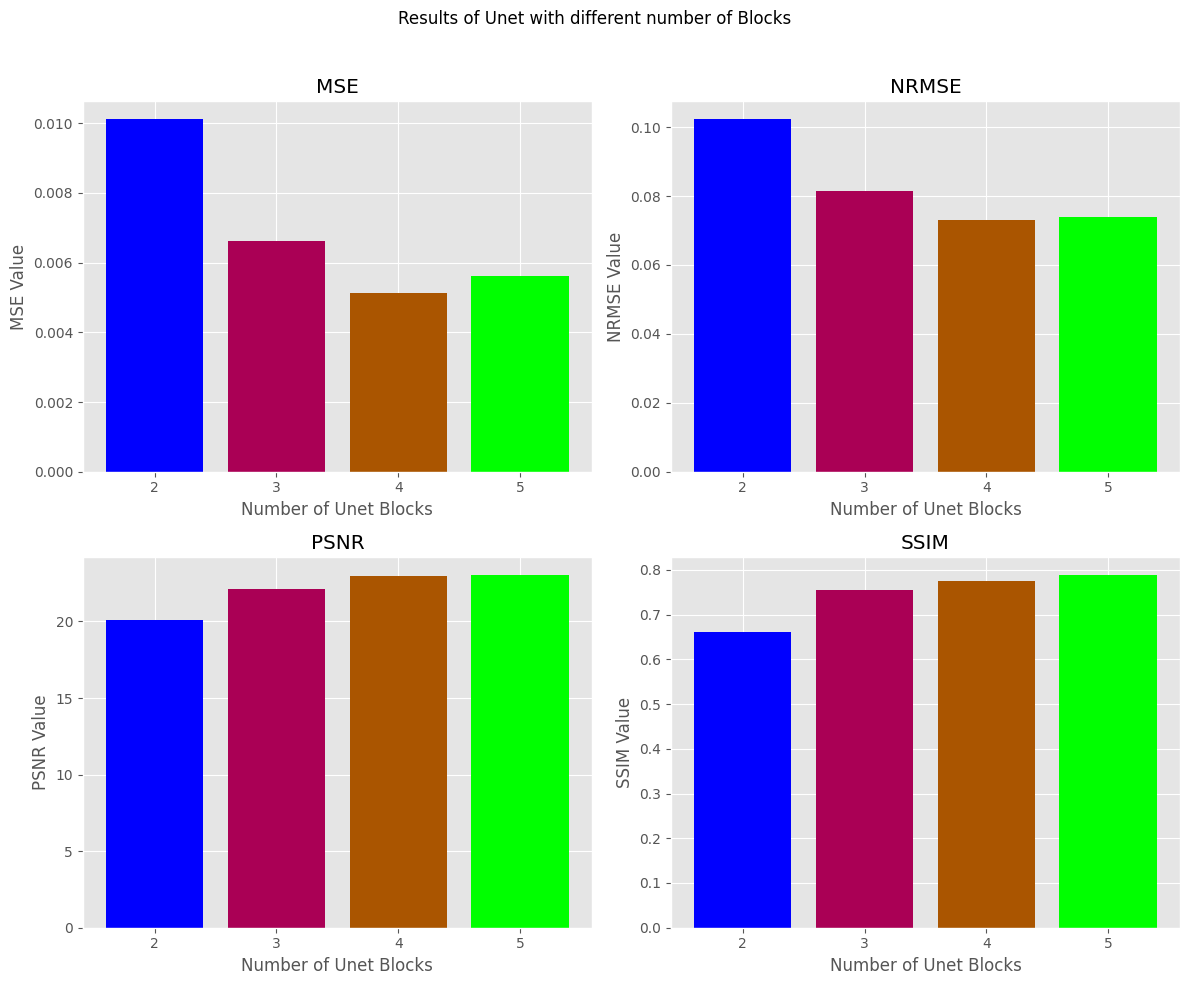

In [25]:
plot_metrics(pd.DataFrame(num_blocks_df), "Results of Unet with different number of Blocks", "Number of Unet Blocks")

## Tuning

In [ ]:
import optuna

EPOCHS = 13


def objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna hyperparameter optimization.

    This function creates a U-Net model with hyperparameters specified by the trial,
    trains the model for a fixed number of epochs, and then calculates the average
    Peak Signal-to-Noise Ratio (PSNR) of the model's predictions on the validation set.

    Parameters
    ----------
    trial : optuna.Trial
        The trial to suggest hyperparameters.

    Returns
    -------
    float
        The average PSNR of the model's predictions on the validation set.

    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    unet_blocks = trial.suggest_int("unet_blocks", 2, 5)
    unet_channels = trial.suggest_categorical("unet_channels", [4, 8, 16, 32])

    model = UNet(num_blocks=unet_blocks, start_channels=unet_channels).to(device)
    UNet_trainer = UnetTrainer(model, lr=lr)
    trainer = pl.Trainer(
        accelerator=device.type,
        max_epochs=EPOCHS,
        check_val_every_n_epoch=EPOCHS,
        limit_val_batches=1,
        enable_progress_bar=False,  # Disable progress bar
        logger=False,  # Disable logging
        enable_checkpointing=False,  # Disable model checkpointing
        enable_model_summary=False,  # Disable model summary
    )
    trainer.fit(UNet_trainer, train_loader)

    # Calculate PSNR on validation set
    model.eval()
    model.to(device)  # It is needed because somehow model is not on cuda
    psnrs = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            for pred, y in zip(y_pred, y_batch):
                pred = pred.detach().cpu().numpy()
                y = y.detach().cpu().numpy()
                psnr = peak_signal_noise_ratio(y, pred, data_range=y.max() - y.min())
                psnrs.append(psnr)
    avg_psnr = np.mean(psnrs)

    return avg_psnr

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=-1)  # 4 w 50 min => 125 min dla 10

[I 2024-06-15 11:31:20,518] A new study created in memory with name: no-name-48b1b74c-a40a-4605-9902-d461a537792b
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightnin

In [ ]:
print(f"Best parameters of model: {study.best_params}, with PSNR: {study.best_value}")

Best parameters of model: {'lr': 0.006926572280942813, 'unet_blocks': 3, 'unet_channels': 16}, with PSNR: 22.63308130621583


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

## Model with best hyperparameters from optuna

In [26]:
best_params = study.best_params
lr = best_params["lr"]
unet_blocks = best_params["unet_blocks"]
unet_channels = best_params["unet_channels"]

best_model = UNet(num_blocks=unet_blocks, start_channels=unet_channels).to(device)

num_params = sum(p.numel() for p in best_model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 1941139


In [27]:
epochs = 30

best_UNet_trainer = UnetTrainer(best_model, lr=lr)

best_trainer = pl.Trainer(
    accelerator=device.type,
    max_epochs=epochs,
    check_val_every_n_epoch=5,
    limit_val_batches=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet    | 1.9 M  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.765     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.27054452896118164


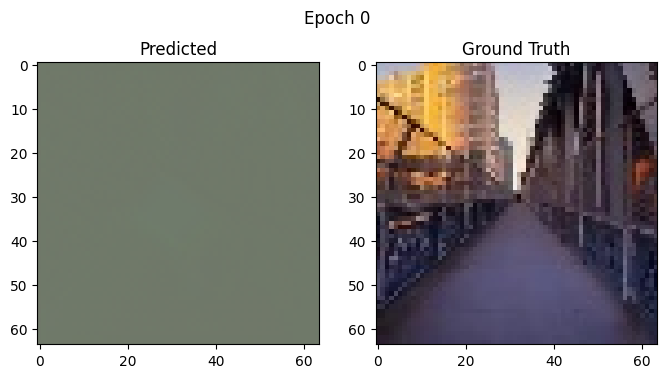

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.03148254007101059


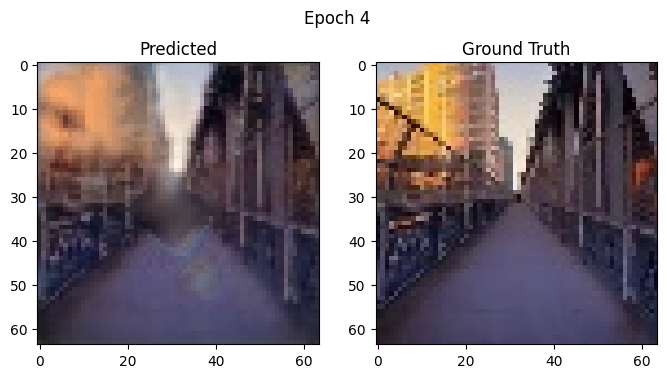

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.023520972579717636


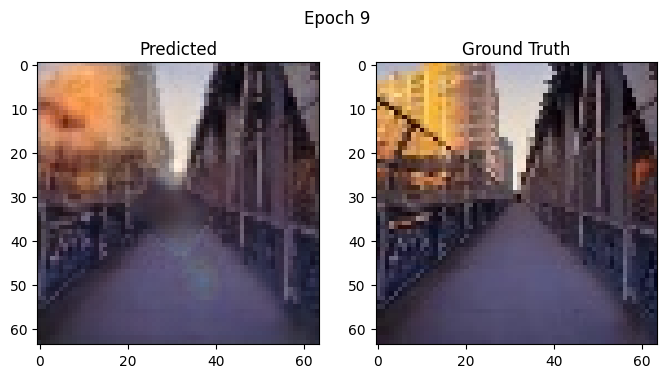

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.2936375141143799


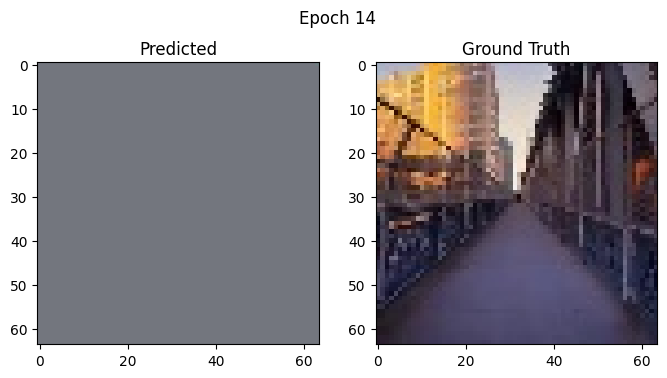

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.2898179888725281


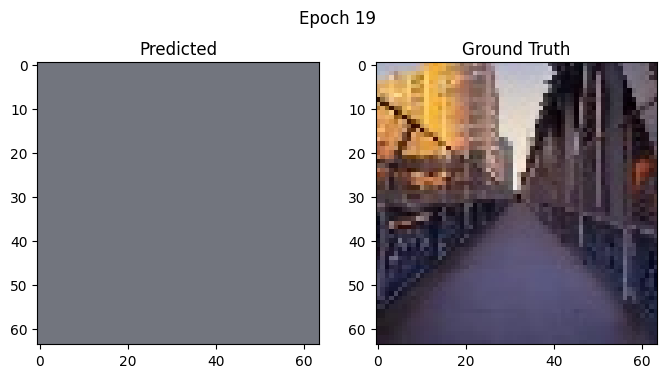

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.29039162397384644


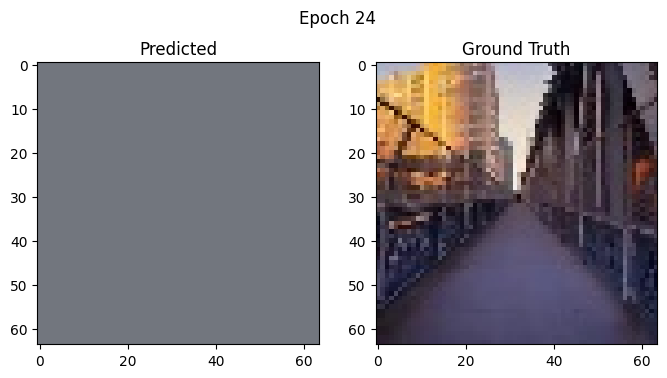

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation loss: 0.28869399428367615


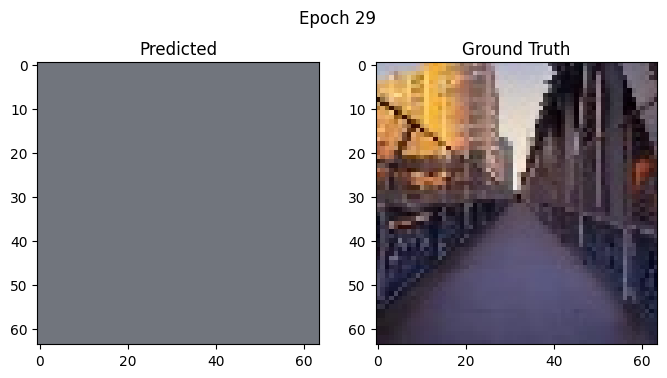

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [28]:
best_trainer.fit(best_UNet_trainer, train_loader, val_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


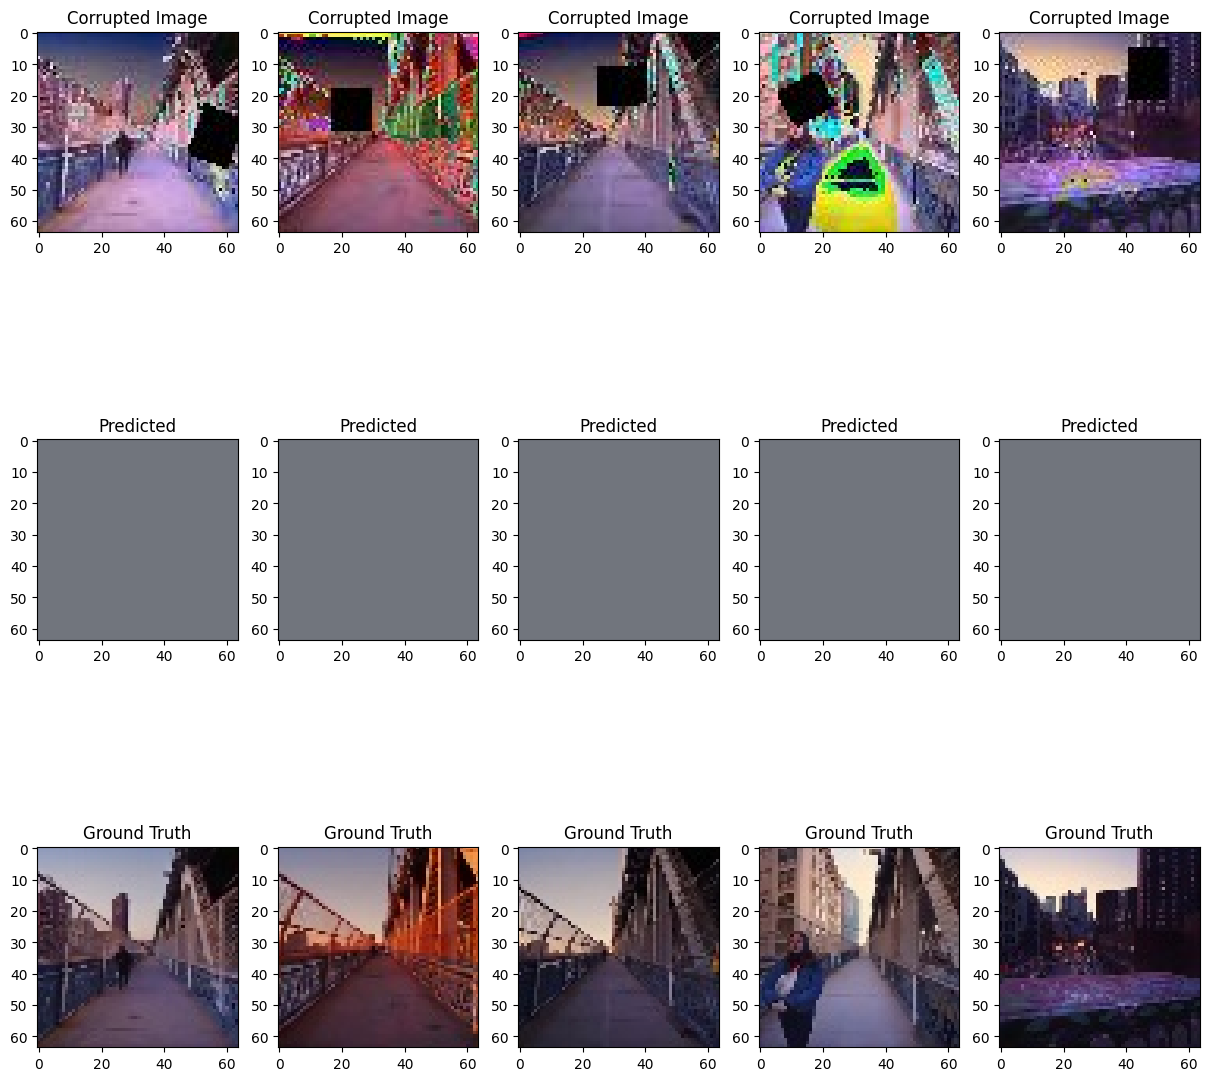

MSE     NRMSE       PSNR      SSIM
max   0.111371  0.377892  14.482017  0.399769
mean  0.057606  0.255360  11.910321  0.207425
min   0.028864  0.188755   8.452644  0.089718

In [29]:
best_model_metrics = evaluate(best_UNet_trainer, test_loader)